In [29]:
fname = "../hanglog/mild_swinging/hdata-2021-01-05_19-24-22.log"
fname = "../hanglog/mild_swinging/hdata-2021-01-11_13-37-07.log"

import os, sys
sys.path.append("..")
import hacktrack.loaders
import pandas, numpy, math
import scipy.optimize
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
from hacktrack.utils import qvec, qmult, InterpT, curvefitdifferentiate, intercurvefitdifferentiate, angularspeedsquaredfromvector
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fd = loaders.FlyDat(fname)
fd.LoadC("ZY")

# assign timevalues in seconds to these tables
fd.pY["t"] = (fd.pY.index - fd.t0)/pandas.Timedelta(seconds=1)
fd.pZ["t"] = (fd.pZ.index - fd.t0)/pandas.Timedelta(seconds=1)

# filter the spikes
Z0 = fd.pY[~fd.pY.bad]
Z1 = fd.pZ[~fd.pZ.bad]


t0 = fd.t0 + pandas.Timedelta(seconds=2)
t1 = t0 + pandas.Timedelta(seconds=58)
A = Z1[t0:t1]


Extracting knowndate from filename: 2021-01-11
E:1, Y:3987, Z:4089, aZ:617, aA:617, aF:607
linAdifftime 2297483.145320197 count 609
Made for Q 0 last index 0
Made for V 0 last index 0
Loading aQV as no pQV records
Made for aQ 0 last index 0
Made for aV 0 last index 0
Missing GPS data, so setting t0 to 2021-01-11 13:34:51.878145
Made for Z 4089 last index 4089
Warning, using guessed (not GPS) timing corrected value on Z 4089
pCattrname pZ
Made for Y 3987 last index 3987
Warning, using guessed (not GPS) timing corrected value on Y 3987
pCattrname pY


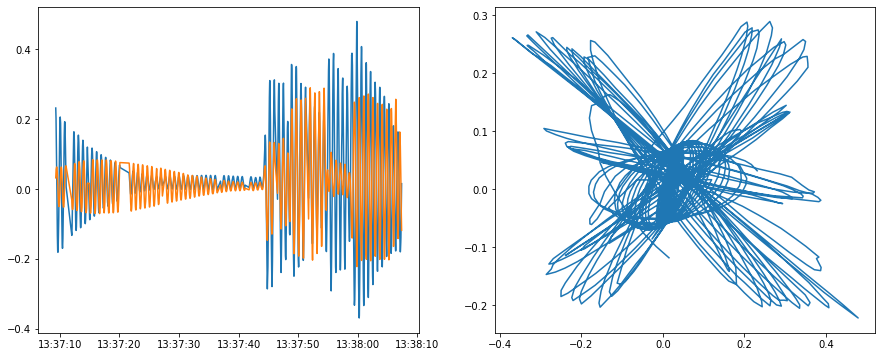

In [30]:
px, py, pz = qvec((A.q0, -A.q1, -A.q2, -A.q3), (0,0,1))
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(px)
plt.plot(py)
plt.subplot(122)
plt.plot(px, py)


In [31]:
ws = 0.18
as2 = angularspeedsquaredfromvector(px, py, pz, ws)

unexplained mismatch by factor of two between the square values


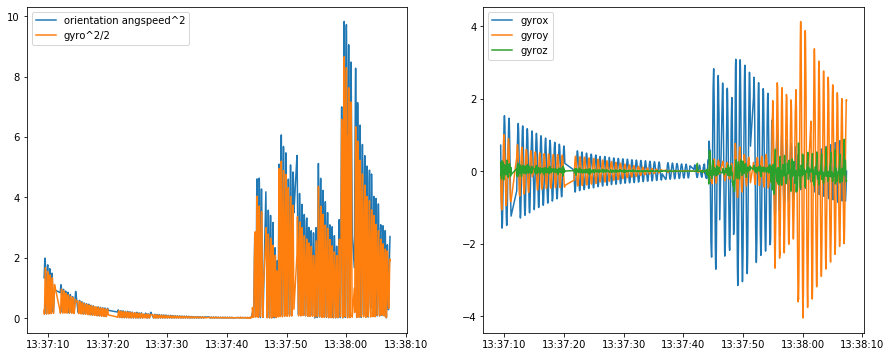

In [36]:
gyrom = A.mx**2 + A.my**2   # radians per second yaw each axis
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(as2, label="orientation angspeed^2")
plt.plot(gyrom*0.5, label="gyro^2/2")
plt.legend()
plt.subplot(122)
plt.plot(A.mx, label="gyrox")
plt.plot(A.my, label="gyroy")
plt.plot(A.mz, label="gyroz")
plt.legend()
print("unexplained mismatch by factor of two between the square values")

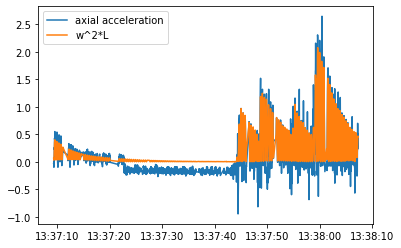

In [38]:
plt.plot(-A.az, label="axial acceleration")
plt.plot((A.mx**2 + A.my**2)*0.12, label="w^2*L")
plt.legend()
print("Is the pendulum length to board 0.12*2 m?")

proof that the angularspeedsquaredfromvector function correctly measures 1rad/sec


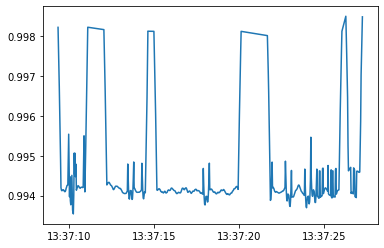

In [43]:
sec1 = pandas.Timedelta(seconds=1)
pt = pandas.Series((px.index-px.index[0])/sec1, px.index)[:t0 + pandas.Timedelta(seconds=18)]
px = numpy.sin(pt)
py = pt*0
pz = numpy.cos(pt)
as2 = angularspeedsquaredfromvector(px, py, pz, 0.18)
plt.plot(as2)
print("proof that the angularspeedsquaredfromvector function correctly measures 1rad/sec")